# This notebook visualize the cell identification applied to an example radar reflectivity snapshot
## The parameters are read from the cell tracking config file

In [175]:
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorcet as cc
from pyflextrkr.ft_utilities import load_config
from pyflextrkr.steiner_func import make_dilation_step_func, peakedness
from pyflextrkr.steiner_func import mod_steiner_classification
from pyflextrkr.steiner_func import expand_conv_core
%matplotlib inline

In [176]:
# Input reflectivity file name
indir = '/pscratch/sd/f/feng045/SAAG/hist/auxhist/refl/2019/'
infile = f'{indir}refl_2019-01-23_21_15_00.nc'

# Cell tracking config file
config_file = '/global/homes/f/feng045/program/pyflex_config/config/config_saag_wrf4km_template.yml'

figdir = '/pscratch/sd/f/feng045/SAAG/hist/cell_tracking/idcell_test/'

option = 'option6'

print(f'Input reflectivity file: {infile}')
print(f'Config file: {config_file}')

Input reflectivity file: /pscratch/sd/f/feng045/SAAG/hist/auxhist/refl/2019/refl_2019-01-23_21_15_00.nc
Config file: /global/homes/f/feng045/program/pyflex_config/config/config_saag_wrf4km_template.yml


In [177]:
# Load configuration file
config = load_config(config_file)
config

{'run_idfeature': False,
 'run_advection': True,
 'run_tracksingle': True,
 'run_gettracks': True,
 'run_trackstats': True,
 'run_mapfeature': True,
 'run_parallel': 0,
 'nprocesses': 24,
 'dask_tmp_dir': '/tmp',
 'timeout': 360,
 'startdate': '20190123.2000',
 'enddate': '20190124.0000',
 'time_format': 'yyyy-mo-dd_hh:mm:ss',
 'databasename': 'refl_',
 'wrfout_path': '/pscratch/sd/f/feng045/SAAG/hist/auxhist/refl/2019/',
 'wrfout_basename': 'refl_',
 'clouddata_path': '/pscratch/sd/f/feng045/SAAG/hist/auxhist/refl/2019/',
 'root_path': '/pscratch/sd/f/feng045/SAAG/hist/cell_tracking/2019/',
 'tracking_path_name': 'tracking',
 'stats_path_name': 'stats',
 'pixel_path_name': 'celltracking',
 'terrain_file': '',
 'rangemask_varname': 'mask110',
 'feature_type': 'radar_cells',
 'advection_field_threshold': 10,
 'advection_med_filt_len': 9,
 'advection_max_movement_mps': 60,
 'advection_mask_method': 'greater',
 'advection_buffer': 6,
 'advection_size_threshold': 10,
 'advection_tiles': [1

## Get cell identification parameters from config

In [178]:
absConvThres = config['absConvThres']
minZdiff = config['minZdiff']
truncZconvThres = config['truncZconvThres']
mindBZuse = config['mindBZuse']
dBZforMaxConvRadius = config['dBZforMaxConvRadius']
conv_rad_increment = config['conv_rad_increment']
conv_rad_start = config['conv_rad_start']
bkg_refl_increment = config['bkg_refl_increment']
maxConvRadius = config['maxConvRadius']
radii_expand = config['radii_expand']
weakEchoThres = config['weakEchoThres']
bkgrndRadius = config['bkgrndRadius']
min_corearea = config['min_corearea']
echotop_gap = config['echotop_gap']
sfc_dz_min = config['sfc_dz_min']
sfc_dz_max = config['sfc_dz_max']
return_diag = config['return_diag']
dx = config['dx']
dy = config['dy']
z_dimname = config.get('z_dimname', 'z')
fillval = config['fillval']
input_source = config['input_source']
geolimits = config.get('geolimits', None)
convolve_method = config.get('convolve_method', 'ndimage')

# sfc_dz_min = config['sfc_dz_min']
# sfc_dz_max = config['sfc_dz_max']
radar_sensitivity = config['radar_sensitivity']
time_dimname = config.get('time', 'time')
x_dimname = config.get('x_dimname', 'x')
y_dimname = config.get('y_dimname', 'y')
z_dimname = config.get('z_dimname', 'z')
x_coordname = config.get('x_coordname')
y_coordname = config.get('y_coordname')
reflectivity_varname = config['reflectivity_varname']

types_steiner = {
    'NO_SURF_ECHO': 1,
    'WEAK_ECHO': 2,
    'STRATIFORM': 3,
    'CONVECTIVE': 4,
}

## Plot Convective Cell Expansion Radius Function

In [179]:
mindBZuse, dBZforMaxConvRadius, bkg_refl_increment, conv_rad_increment, conv_rad_start, maxConvRadius

(25, 60, 5, 0.75, 4.0, 8.0)

In [180]:
# Convert radii_expand from a list to a numpy array
radii_expand = np.array(radii_expand)

# Make step function for convective radius dilation
bkg_bin, conv_rad_bin = make_dilation_step_func(
    mindBZuse,
    dBZforMaxConvRadius,
    bkg_refl_increment,
    conv_rad_increment,
    conv_rad_start,
    maxConvRadius,
)
# Repeat first value in array for plotting purpose
conv_rad_bin = np.insert(conv_rad_bin, 0, conv_rad_bin[0])

print(bkg_bin)
print(conv_rad_bin)

[  0.  25.  30.  35.  40.  45.  50.  55.  60. 100.]
[4.   4.   4.75 5.5  6.25 7.   7.75 8.   8.   8.  ]


In [181]:
# Steiner et al. (1995) step function
bkg_bin_steiner, conv_rad_bin_steiner = make_dilation_step_func(
    25,
    60.0,
    5.0,
    1.0,
    1.0,
    5.0,
)
# Repeat first value in array for plotting purpose
conv_rad_bin_steiner = np.insert(conv_rad_bin_steiner, 0, conv_rad_bin_steiner[0])

## Calculate expansion thresholds

In [182]:
dx_km = dx / 1000.
dx_km_diag1 = np.sqrt(dx_km**2 + dx_km**2)
dx_km_diag2 = np.sqrt(dx_km**2 + (2*dx_km)**2)
# print(dx_km_diag1)
# print(dx_km_diag2)
expand_hv = np.arange(min(conv_rad_bin), max(conv_rad_bin)*1.0001, dx_km)
expand_diag1 = np.arange(dx_km_diag1, max(conv_rad_bin)*1.0001, dx_km_diag1)
expand_diag2 = np.arange(dx_km_diag2, max(conv_rad_bin)*1.0001, dx_km_diag2)
print(f'Horizontal/vertical expansion: {expand_hv} km')
print(f'Diagonal expansion x1: {expand_diag1} km') 
print(f'Diagonal expansion x2: {expand_diag2} km')

Horizontal/vertical expansion: [4. 8.] km
Diagonal expansion x1: [5.65685425] km
Diagonal expansion x2: [] km


'/pscratch/sd/f/feng045/SAAG/hist/cell_tracking/idcell_test/convective_radius_dilation_stepfunction_option6.png'

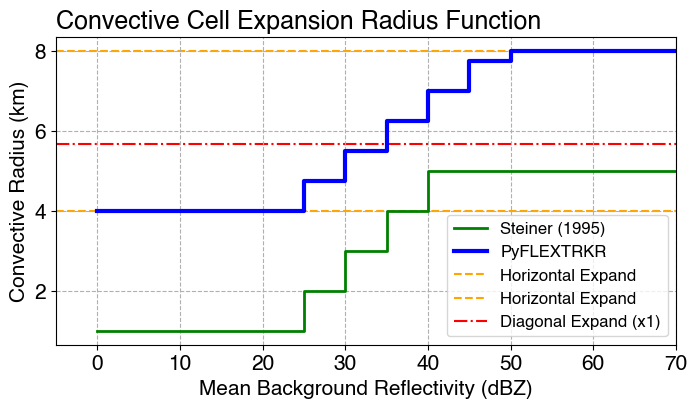

In [183]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'

fig = plt.figure(figsize=[8,4], dpi=100)
ax = plt.subplot()
ax.step(bkg_bin_steiner, conv_rad_bin_steiner, '-', lw=2, color='g', label='Steiner (1995)')
ax.step(bkg_bin, conv_rad_bin, '-', lw=3, color='b', label='PyFLEXTRKR')
# Plot expansion threshold lines
for ii in range(len(expand_hv)):
    ax.axhline(expand_hv[ii], color='orange', ls='--', zorder=0, label='Horizontal Expand')
for ii in range(len(expand_diag1)):
    ax.axhline(expand_diag1[ii], color='r', ls='-.', zorder=0, label='Diagonal Expand (x1)')
for ii in range(len(expand_diag2)):
    ax.axhline(expand_diag2[ii], color='magenta', ls='-', zorder=0, label='Diagonal Expand (x2)')
# Label axes
ax.set_xlabel('Mean Background Reflectivity (dBZ)')
ax.set_ylabel('Convective Radius (km)')
ax.set_title('Convective Cell Expansion Radius Function', loc='left')
ax.grid(ls='--')
ax.legend(fontsize=12)
ax.set_xlim(-5, 70)
# ax.set_ylim(0, 6)

figname = f'{figdir}convective_radius_dilation_stepfunction_{option}.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
figname

## Plot Convective Core Peakedness Function

In [184]:
# Make background reflectivity array
refl_bkg = np.linspace(-10, 70, 1000)
mask_goodvalues = np.ones(len(refl_bkg))

# Make peakedness curve
peak = peakedness(refl_bkg, mask_goodvalues, minZdiff, absConvThres)
# Steiner et al. (1995) peakedness curve
peak_steiner = peakedness(refl_bkg, mask_goodvalues, minZdiff, 42.23)

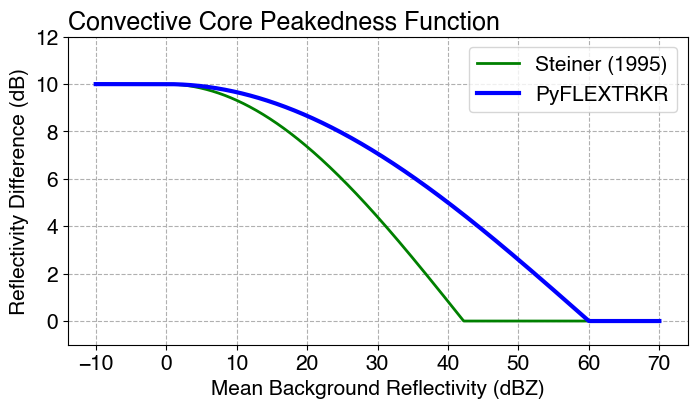

In [185]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'

fig = plt.figure(figsize=[8,4], dpi=100)
ax = plt.subplot()
ax.plot(refl_bkg, peak_steiner, '-', lw=2, color='g', label='Steiner (1995)')
ax.plot(refl_bkg, peak, '-', lw=3, color='b', label='PyFLEXTRKR')
ax.set_xlabel('Mean Background Reflectivity (dBZ)')
ax.set_ylabel('Reflectivity Difference (dB)')
ax.set_title('Convective Core Peakedness Function', loc='left')
ax.grid(ls='--')
ax.set_ylim(-1, 12)
ax.legend()

# figname = f'{figdir}reflectivity_peakedness_curve.png'
# fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

## Read sample radar data

In [186]:
# Read input data
ds = xr.open_dataset(infile)
# grid_lon = ds[x_coordname].squeeze()
# grid_lat = ds[y_coordname].squeeze()
ds

<xarray.Dataset>
Dimensions:    (lat: 110, lon: 94, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-23T21:15:00
Dimensions without coordinates: lat, lon
Data variables:
    longitude  (lat, lon) float32 ...
    latitude   (lat, lon) float32 ...
    tb         (time, lat, lon) float32 ...
    rainrate   (time, lat, lon) float64 ...
    REFL_COM   (time, lat, lon) float32 ...
Attributes:
    Title:        WRF subset auxhist data
    Contact:      Zhe Feng: zhe.feng@pnnl.gov
    Institution:  Pacific Northwest National Laboratory
    created on:   Tue Feb 13 15:42:12 2024
    DX:           4000.0
    DY:           4000.0

In [187]:
# Get radar variables
dbz_comp = ds[reflectivity_varname].squeeze()
    
# Make a copy of the composite reflectivity (must do this or the dbz_comp will be altered)
refl = np.copy(dbz_comp.values)
# Replace all values less than min radar sensitivity, including NAN, to be equal to the sensitivity value
# The purpose is to include areas surrounding isolated cells below radar sensitivity
# in the background intensity calculation.
# This differs from Steiner.
refl[(refl < radar_sensitivity) | np.isnan(refl)] = radar_sensitivity
# Create a good value mask (everywhere is good for WRF)
mask_goodvalues = np.full(dbz_comp.shape, 1, dtype=int)

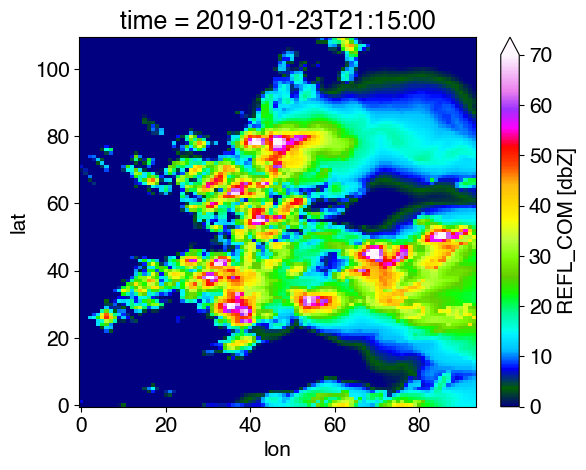

In [188]:
dbz_comp.plot(vmin=0, vmax=70, cmap='gist_ncar')

## Run Steiner classification

In [189]:
convsf_steiner, \
core_steiner, \
core_dilate, \
refl_bkg, \
peakedness, \
core_steiner_orig = mod_steiner_classification(
    types_steiner, refl, mask_goodvalues, dx, dy,
    bkg_rad=bkgrndRadius * 1000,
    minZdiff=minZdiff,
    absConvThres=absConvThres,
    truncZconvThres=truncZconvThres,
    weakEchoThres=weakEchoThres,
    bkg_bin=bkg_bin,
    conv_rad_bin=conv_rad_bin,
    min_corearea=min_corearea,
    remove_smallcores=True,
    return_diag=return_diag,
    convolve_method=convolve_method,
)

## Expand convective cell masks outward to a set of radii to increase the convective cell footprint for tracking

In [190]:
core_expand, core_sorted = expand_conv_core(core_dilate, radii_expand, dx, dy, min_corenpix=0)

In [191]:
time_str = ds[time_dimname].dt.strftime('%Y-%m-%d  %H:%M:%S').item()
time_fig = ds[time_dimname].dt.strftime('%Y%m%d_%H%M%S').item()
time_str, time_fig

('2019-01-23  21:15:00', '20190123_211500')

'/pscratch/sd/f/feng045/SAAG/hist/cell_tracking/idcell_test/idcell_20190123_211500_option6.png'

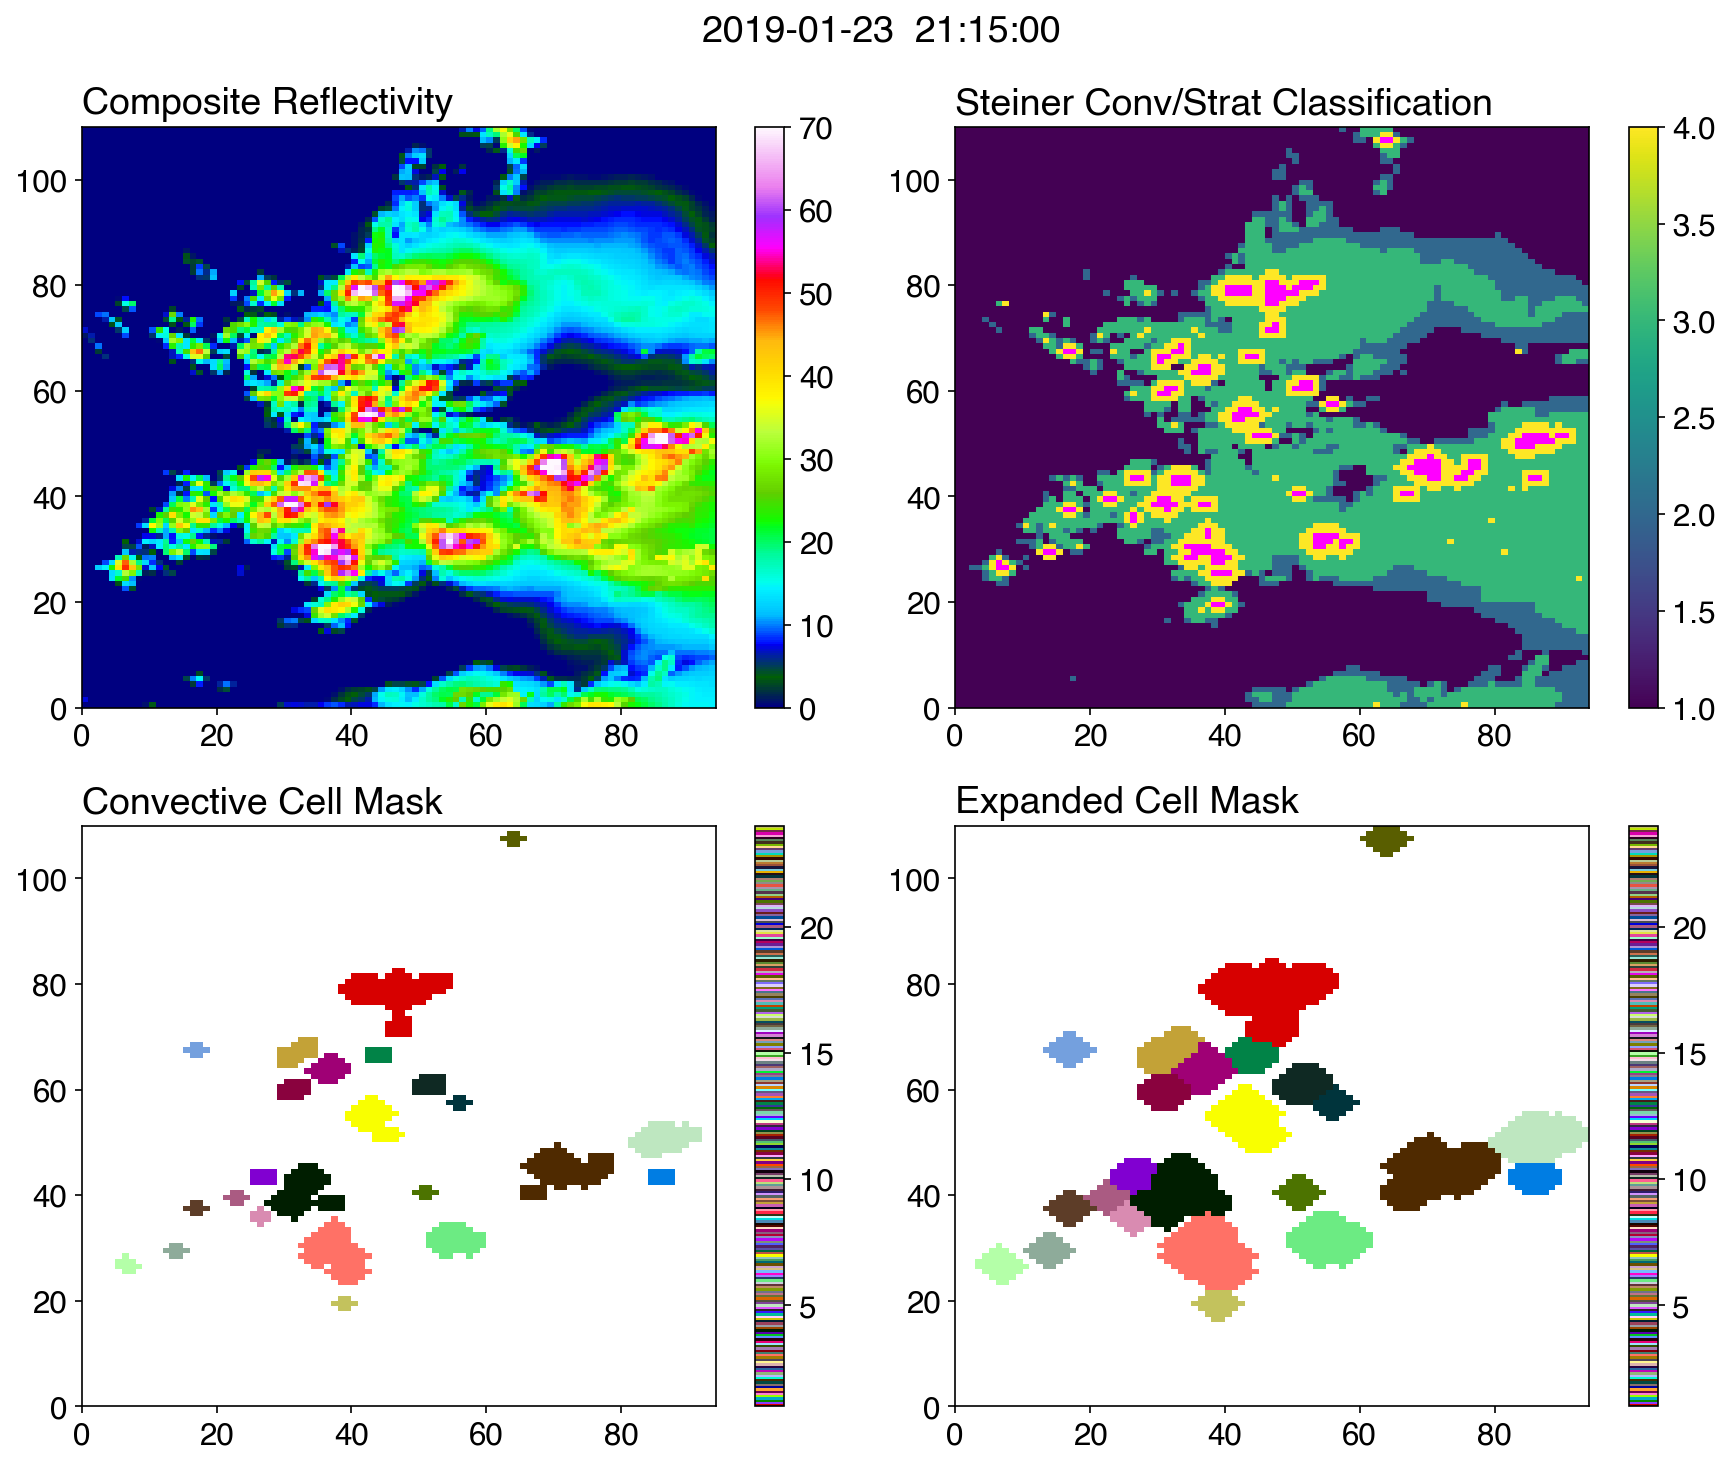

In [192]:
fig, axes = plt.subplots(2, 2, figsize=[12,10], dpi=150)
ax0 = axes[0,0]
cm0 = ax0.pcolormesh(dbz_comp, vmin=0, vmax=70, cmap='gist_ncar')
ax0.set_title('Composite Reflectivity', loc='left')
plt.colorbar(cm0, ax=ax0)

ax1 = axes[0,1]
# Steiner conv/strat/weak classification
cm1 = ax1.pcolormesh(convsf_steiner)
# Overplot Steiner core
Zm_core = np.ma.masked_where(core_steiner==0, core_steiner)
cm2 = ax1.pcolormesh(Zm_core, vmin=1, vmax=2, cmap='spring')
ax1.set_title('Steiner Conv/Strat Classification', loc='left')
plt.colorbar(cm1, ax=ax1)

ax2 = axes[1,0]
core_mask = core_expand * core_dilate
Zm = np.ma.masked_where(core_mask == 0, core_expand)
cm2 = ax2.pcolormesh(Zm, cmap=cc.cm['glasbey_bw'])
ax2.set_title('Convective Cell Mask', loc='left')
plt.colorbar(cm2, ax=ax2)

ax3 = axes[1,1]
Zm = np.ma.masked_where(core_expand == 0, core_expand)
cm3 = ax3.pcolormesh(Zm, cmap=cc.cm['glasbey_bw'])
ax3.set_title('Expanded Cell Mask', loc='left')
plt.colorbar(cm3, ax=ax3)

fig.suptitle(time_str)
fig.tight_layout()

figname = f'{figdir}idcell_{time_fig}_{option}.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
figname

In [193]:
# Create variables needed for tracking
feature_mask = core_expand
# Count number of pixels for each feature
unique_num, npix_feature = np.unique(feature_mask, return_counts=True)
# Remove background (unique_num = 0)
npix_feature = npix_feature[(unique_num > 0)]
# Get number of features
nfeatures = np.nanmax(feature_mask)

In [194]:
npix_feature

array([209, 176, 143, 131, 109,  99, 101,  56,  58,  54,  44,  35,  41,
        40,  36,  32,  24,  30,  32,  26,  32,  28,  32,  30])